In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import deep_gravity_utils as dgu

np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Linear regression

## Model formulation

In [2]:
config = pd.read_csv('config.csv', index_col=0)
config

,t_past,t_pre,prop,mask,year
0,5,4,0.7,0,2019


In [3]:
year = config.loc[0, 'year']
OD = np.load('./data/3d_%i_30days.npy'%year)[:48, :48]
OD.shape

(48, 48, 720)

In [4]:
t_past = config.loc[0, 't_past']
t_pre = config.loc[0, 't_pre']
t_past = 5
t_pre = 4

OD_4d = dgu.const_4d_OD(OD, t_past, t_pre)
OD_4d = np.transpose(OD_4d, (1,2,3,0))
print(OD_4d.shape)

Memory occupied 113.9062 MB
(9, 48, 48, 711)


In [5]:
X = OD_4d[:t_past, :, :, :]
y = OD_4d[t_past:, :, :, :]

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (5, 48, 48, 711)
Shape of y: (4, 48, 48, 711)


In [6]:
prop = config.loc[0, 'prop']
l = int(prop*X.shape[-1])

X_train = X[:, :, :, :l].reshape(t_past, -1).T
X_val = X[:, :, :, l:].reshape(t_past, -1).T
y_train = y[:, :, :, :l].reshape(t_pre, -1).T
y_val = y[:, :, :, l:].reshape(t_pre, -1).T

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}')


Shape of X_train: (1145088, 5)
Shape of y_train: (1145088, 4)
Shape of X_val: (493056, 5)
Shape of y_val: (493056, 4)


In [7]:
reg = LinearRegression().fit(X_train, y_train)
# print(f'Coefficients =\n{reg.coef_}\n')
# print(f'Intercepts = {reg.intercept_}\n')
# print(f'R^2 = {reg.score(X, y):.4f}')

## Evaluation

The mae loss is 6.2140
The mape loss is 1.2171
The smape loss is 1.3473
The nrmse loss is 0.0253
The nmae loss is 0.0072
CPC is 0.49351


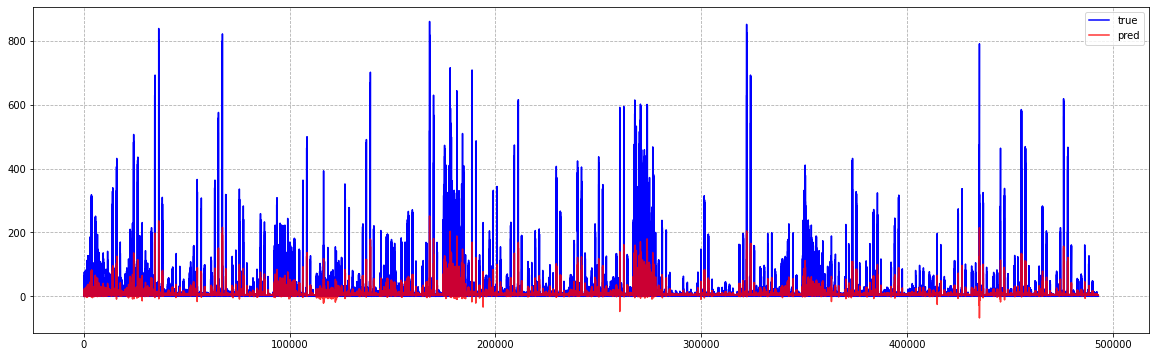

In [8]:
pred = reg.predict(X_val)
np.save('./res/%.1f/lr_%i.npy'%(prop, year), pred)
np.save('./res/%.1f/labels_%i.npy'%(prop, year), y_val)

m = config.loc[0, 'mask']

print('The mae loss is %.4f'%dgu.mae_loss_func(pred, y_val, m))
print('The mape loss is %.4f'%dgu.mape_loss_func(pred, y_val, m))
print('The smape loss is %.4f'%dgu.smape_loss_func(pred, y_val, m))
print('The nrmse loss is %.4f'%dgu.nrmse_loss_func(pred, y_val, m))
print('The nmae loss is %.4f'%dgu.nmae_loss_func(pred, y_val, m))
print('CPC is %.5f'%dgu.get_CPC(pred, y_val))


plt.figure(figsize=[20, 6])
plt.plot(y_val[:, t_pre-1], '-', label='true', c='b')
plt.plot(pred[:, t_pre-1], '-', label='pred', c='r', alpha=0.8)
plt.legend()
plt.grid(ls='--')

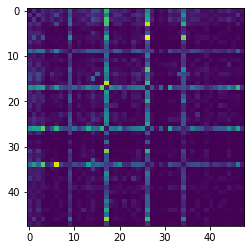

In [9]:
plt.imshow(pred.T.reshape(4, 48, 48, -1).sum(axis=3)[0,:,:])